In [71]:
import json
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

%matplotlib inline  

In [5]:
references = pd.read_csv('data/References.csv', index_col=0)

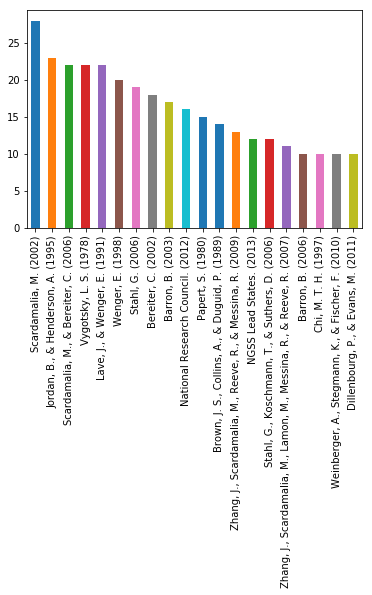

In [7]:
references.ref_parsed.value_counts().head(20).plot(kind='bar')

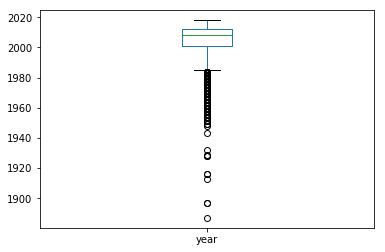

In [8]:
references.year.plot(kind='box')

# Merge names with references:

In [15]:
metadata = pd.read_csv('data/Parsed_metadata.csv')

In [52]:
reference_authors = pd.read_csv('data/Reference_authors.csv', index_col=0)
reference_authors.shape

(20730, 2)

In [54]:
reference_authors.drop_duplicates(inplace=True)
reference_authors.shape

(17627, 2)

In [55]:
reference_authors.head()

,author,file
0,Abrahamson D.,import2016full/61
3,Lee R. G.,import2016full/61
4,Negrete A. G.,import2016full/61
5,Gutiérrez J. F.,import2016full/61
7,Sánchez-García R.,import2016full/61


In [56]:
reference_edges = pd.merge(metadata, reference_authors, on='file')[['shortend_names', 'author']]

In [57]:
reference_edges.columns = ['author', 'cited']

People who like to cite themselves:

In [58]:
reference_edges[reference_edges.author == reference_edges.cited].author.value_counts().head()

Dillenbourg P.    11
Zhang J.          11
Rummel N.         10
Puntambekar S.    10
Slotta J. D.       9
Name: author, dtype: int64

In [59]:
set(reference_edges.author.tolist()) in set(reference_edges.cited.tolist())

False

In [60]:
print('Number of distinct authors ', len(reference_edges.author.unique()))
print('Number of distinct cited authors by some author in the conference ', len(reference_edges.cited.unique()))
print('Number of authors that where cited by an other author in the confernce :' , len(set(reference_edges.cited.tolist()).intersection(set(reference_edges.author.tolist()))))

Number of distinct authors  1010
Number of distinct cited authors by some author in the conference  8210
Number of authors that where cited by an other author in the confernce : 570


In [61]:
not_in_conference = list(set(reference_edges.cited) - set(reference_edges.author))

In [62]:
reference_edges['participated'] = reference_edges.cited.map(lambda x : 0 if x in not_in_conference else 1)

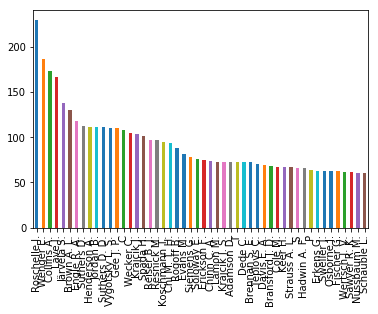

In [63]:
reference_edges[reference_edges.participated == 0].cited.value_counts().head(50).plot(kind = 'bar')

## References

In [66]:
references = pd.read_csv('data/References.csv', index_col=0)

In [69]:
references.ref.sample(5).tolist()

['Bielaczyc, K., & Collins, A. (1999). Learning communities in classrooms: A reconceptualization of educational practice. Instructional-Design Theories and Models: A New Paradigm of Instructional Theory, 2, 269– 292.',
 'Vosniadou, S., & Verschaffel, L. (2004). Extending the conceptual change approach to mathematics learning and teaching. Special Issue of Learning and Instruction, 14(5), 445–451.',
 'Gee, J. P. (2003). What video games have to teach us about learning and literacy. New York, NY: Palgrave Macmillan.',
 'Ito, M., Gutiérrez, K., Livingstone, S., Penuel, B., Rhodes, J., Salen, K., … Watkins, S. C. (2013). Connected learning: An agenda for research and design. Digital Media and Learning Research Hub. Retrieved from http://eprints.lse.ac.uk/48114',
 'Mercier, E. M., Higgins, S. E., & da Costa, L. (2014). Different leaders: Emergent organizational and intellectual leadership in children’s collaborative learning groups. International Journal of Computer-Supported Collaborative 

# Building the refrence graph:

directed graph weighted by number of times x cited y:

In [52]:
nodes = pd.DataFrame(reference_edges.author.drop_duplicates().reset_index(drop=True)).reset_index()

In [53]:
nodes.head()

,index,author
0,0,Mahoney C.
1,1,Danish J.
2,2,DeLiema D.
3,3,Enyedy N.
4,4,Saleh A.


In [54]:
edges = pd.merge(nodes, reference_edges, left_on='author', right_on='cited')
del edges['author_x']

In [55]:
edges = pd.merge(nodes, edges, left_on='author', right_on='author_y')
del edges['author_y'], edges['author'], edges['cited']

In [56]:
edges.columns = ['author', 'citation']

In [57]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    if np.isnan(row.author):
        continue
    i, j = int(row.author), int(row.citation)
    adjacency[j, i] += 1

In [58]:
adjacency.shape

(1010, 1010)

In [59]:
degrees = np.where(adjacency > 0, 1, 0).sum(axis=0)

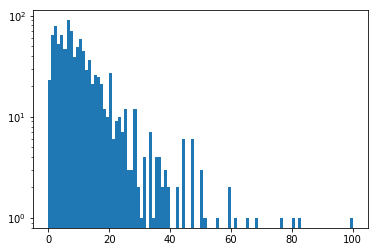

In [60]:
plt.hist(degrees, bins=100, log=True)
plt.show()

In [61]:
import networkx as nx

graph = nx.from_numpy_array(adjacency)

mapping = nodes.author.to_dict()

H=nx.relabel_nodes(graph,mapping)
print(sorted(H.nodes()))

nx.write_gexf(H, 'data/refrence_graph.gexf')

['Aalst J.', 'Abdu R.', 'Abrahamson D.', 'Acosta A.', 'Adanır G. A.', 'Aditomo A.', 'Adleberg B.', 'Agrawal H.', 'Ahn J.', 'Ahonen A. K.', 'Ainsworth S.', 'AlQahtani M.', 'Alameh S.', 'Albrecht J.', 'Aleven V.', 'Allen C. D.', 'Allen L.', 'Allert H.', 'Almatrafi O.', 'Alqassab M.', 'Alstyne R.', 'Amzalag M.', 'Anderson C. G.', 'Anderson E.', 'Anderson J.', 'Anderson R. C.', 'Andrade A.', 'Andrews J. J.', 'Angelo S.', 'Angersbach J.', 'Anjewierden A.', 'Antle A. N.', 'Apollonia S.', 'Applebaum L.', 'Applebaum L. R.', 'Arastoopour G.', 'Arnedillo-Sanchez I.', 'Arnseth H. C.', 'Arvaja M.', 'Arvidsson T. S.', 'Ashley R. W.', 'Askari E.', 'Asterhan C.', 'Awwal N.', 'Ayer T.', 'Azevedo F. S.', 'Azevedo R.', 'Baker R.', 'Bakker A.', 'Bal A.', 'Baltes J.', 'Bang M.', 'Bannan B.', 'Baram-Tsabari A.', 'Barber-Lester K.', 'Barber-Lester K. J.', 'Barcellos M. E.', 'Barrat A.', 'Barron B.', 'Barth-Cohen L. A.', 'Barton A. C.', 'Baruch A. F.', 'Barzilai S.', 'Basu S.', 'Beck S.', 'Becker S.', 'Bell 